In [27]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

from scipy.optimize import differential_evolution
from scipy.stats.qmc import Halton

# General imports
import os
import json
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

# custom module
from susy_qm import calculate_Hamiltonian

In [53]:
potential = 'QHO'
#potential = 'AHO'
#potential = 'DW'
cut_off = 16

In [54]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [55]:
#Initial params shape
num_layers = 1
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)

In [56]:
def ansatz(params, wires):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(weights=params, wires=wires, imprimitive=qml.CZ)

In [57]:
# Device
shots = 10000
#shots = None
dev = qml.device('lightning.qubit', wires=2*num_qubits+1, shots=shots)

@qml.qnode(dev)
def swap_test(params1, params2):

    params1 = pnp.tensor(params1.reshape(params_shape), requires_grad=True)
    params2 = pnp.tensor(params2.reshape(params_shape), requires_grad=True)

    ancilla = 2*num_qubits
    qml.Hadamard(wires=ancilla)

    ansatz(params1, wires=range(num_qubits))
    ansatz(params2, wires=range(num_qubits, 2*num_qubits))

    qml.Barrier()
    for i in range(num_qubits):
        qml.CSWAP(wires=[ancilla, i, num_qubits + i])

    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)

In [58]:
def swap_test_with_copies(params1_list, params2_list, P):
    
    results = []

    for _ in range(P):

        prob = swap_test(params1_list, params2_list)
        results.append(prob[0])  # Probability of ancilla qubit in |0>
    
    # Average the probabilities
    avg_prob = sum(results) / P

    # Compute overlap from the averaged probability
    overlap = 2 * avg_prob - 1

    return overlap


In [7]:
# Example parameters for testing the swap test
params1 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))
params2 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))

# Run the swap test to get the probability of the ancilla being |0>
result = swap_test(params1, params2)

# The overlap is given by 2 * P(ancilla=0) - 1
#overlap = 2 * result[0] - 1
overlap = 2*result[0] -1

print(qml.draw(swap_test)(params1,params2))
print(f"\nOverlap between the ground state and the ansatz: {overlap}")

 0: ──Rot(4.37,1.94,3.94)─╭●──────────╭Z──||─╭SWAP────────────────────────────┤       
 1: ──Rot(4.42,1.74,4.42)─╰Z─╭●───────│───||─│─────╭SWAP──────────────────────┤       
 2: ──Rot(1.52,1.57,1.84)────╰Z─╭●────│───||─│─────│─────╭SWAP────────────────┤       
 3: ──Rot(5.72,1.25,5.00)───────╰Z─╭●─│───||─│─────│─────│─────╭SWAP──────────┤       
 4: ──Rot(3.94,2.01,2.02)──────────╰Z─╰●──||─│─────│─────│─────│─────╭SWAP────┤       
 5: ──Rot(1.12,5.34,2.31)─╭●──────────╭Z──||─├SWAP─│─────│─────│─────│────────┤       
 6: ──Rot(5.61,1.61,0.96)─╰Z─╭●───────│───||─│─────├SWAP─│─────│─────│────────┤       
 7: ──Rot(4.61,2.85,1.87)────╰Z─╭●────│───||─│─────│─────├SWAP─│─────│────────┤       
 8: ──Rot(0.67,2.97,5.19)───────╰Z─╭●─│───||─│─────│─────│─────├SWAP─│────────┤       
 9: ──Rot(0.27,5.16,1.79)──────────╰Z─╰●──||─│─────│─────│─────│─────├SWAP────┤       
10: ──H───────────────────────────────────||─╰●────╰●────╰●────╰●────╰●─────H─┤  Probs

Overlap between the ground state and the a

In [59]:
# Device
shots = 1024
dev2 = qml.device('lightning.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev2)
def expected_value(params):
    wires = range(num_qubits)
    ansatz(params, wires)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

In [60]:
P = 100
def loss_f(params):
    global prev_param_list, beta
    energy = expected_value(params)

    penalty = 0

    if len(prev_param_list) != 0:
        for prev_param in prev_param_list:
            overlap = swap_test_with_copies(prev_param, params, P)
            penalty += (beta*overlap)

    return energy + (penalty)

In [26]:
def callback(xk, convergence):
    global iteration_counter, counts, values
    
    current_cost = loss_f(xk)

    iteration_counter += 1
    counts.append(iteration_counter) 
    values.append(current_cost)

In [61]:
vqd_start = datetime.now()

#variables
num_energy_levels = 2
max_iter = 500
beta = 2.0

strategy = "randtobest1bin"
tol = 1e-3
abs_tol = 1e-3
popsize = 20

mutation=(0.5, 1.0)  # Default (0.5, 1.0)
recombination=0.9   # Default 0.7

#data arrays
energies = []
prev_param_list = []
num_iters = []
run_times = []
success = []
run_times = []

all_counts = []
all_values = []
all_overlaps = []


#Optimizer
bounds = [(0, 2 * np.pi) for _ in range(np.prod(params_shape))]

# We need to generate a random seed for each process otherwise each parallelised run will have the same result
seed = (os.getpid() * int(time.time())) % 123456789
run_start = datetime.now()

# Generate Halton sequence
num_dimensions = np.prod(params_shape)
num_samples = popsize
halton_sampler = Halton(d=num_dimensions, seed=seed)
halton_samples = halton_sampler.random(n=num_samples)
scaled_samples = 2 * np.pi * halton_samples

for i in range(num_energy_levels):

    run_start = datetime.now()

    iteration_counter = 0
    counts = []
    values = []    

    if i % 1 == 0:
        print(f"Run: {i}")


    # Differential Evolution optimization
    res = differential_evolution(loss_f, 
                                    bounds, 
                                    maxiter=max_iter, 
                                    tol=tol,
                                    atol=abs_tol,
                                    strategy=strategy, 
                                    popsize=popsize,
                                    #recombination=recombination,
                                    init=scaled_samples,
                                    seed=seed,
                                    callback=callback)
    
    all_counts.append(counts)
    all_values.append(values)        


    energies.append(res.fun)
    prev_param_list.append(res.x) 
    num_iters.append(res.nfev)
    success.append(res.success)

    run_end = datetime.now()
    run_time = run_end - run_start
    run_times.append(run_time)

    print(energies)

    '''
    # Calculate overlap with all previous states
    overlaps = []
    if i > 0:
        for j in range(i):
            overlap =  1 - (2*swap_test(prev_param_list[j], res.x)[1])
            overlaps.append(overlap)
        all_overlaps.append(overlaps)
        print(f"Overlaps with all previous states for run {i}: {overlaps}")
    '''
vqd_end = datetime.now()
vqd_time = vqd_end - vqd_start


Run: 0
[0.0]
Run: 1
[0.0, 1.000081125]


In [62]:
eigenvalues.real

array([ 0.,  1.,  1.,  2.,  2.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,
        7.,  7.,  7.,  8.,  8.,  8.,  9.,  9., 10., 10., 11., 11., 12.,
       12., 13., 13., 14., 14., 15.])

In [63]:
success

[True, True]

In [73]:
#Save run
run = {
    'potential': potential,
    'cutoff': cut_off,
    'exact_eigenvalues': [x.real.tolist() for x in eigenvalues],
    'ansatz': 'StronglyEntanglingLayers-1layer',
    'num_VQD': num_energy_levels,
    "Optimizer": {
                    "name": "differential_evolution",
                    "bounds": "[(0, 2 * np.pi) for _ in range(np.prod(params_shape))]",
                    "maxiter": max_iter,
                    "tolerance": tol,
                    "abs_tolerance": abs_tol,
                    "strategy": strategy,
                    "popsize": popsize,
                    'init': 'scaled_samples',
                },
    'converged_energies': energies,
    'converged_params': [x.tolist() for x in prev_param_list],
    'energies': all_values,
    'num_iters': all_counts,
    'success': np.array(success, dtype=bool).tolist(),
    'run_times': [str(x) for x in run_times],
    'total_run_time': str(vqd_time)
}

'''
# Save the variable to a JSON file

starttime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder = str(starttime)
#Create directory for files
#base_path = r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\PennyLane\VQD\COBYLA\Files\{}\\{}\\".format(potential, folder)
base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\SUSY\PennyLane\VQD\Differential Evolution\Files\{}\\{}\\".format(potential, folder)
os.makedirs(base_path)

path = base_path + "{}_{}.json".format(potential, cut_off)
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)
'''

In [74]:
file_path = path
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

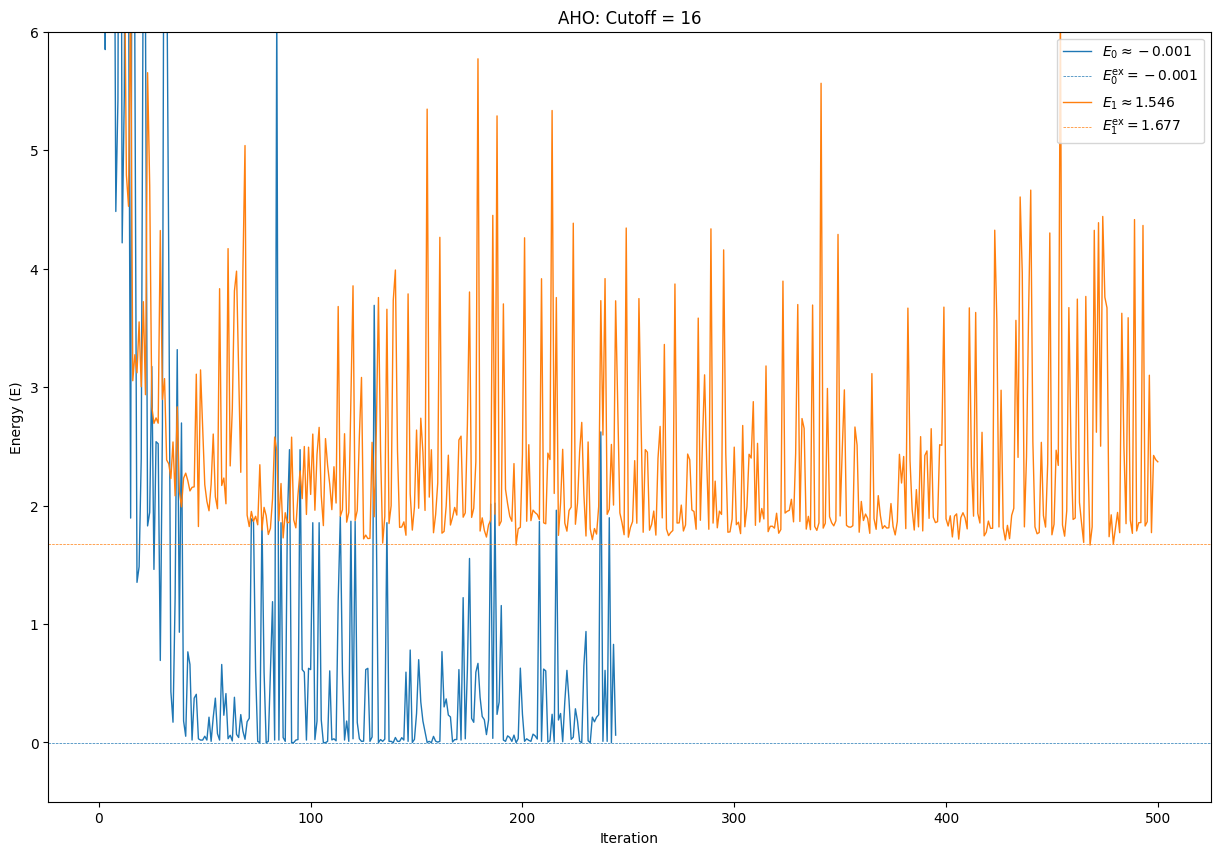

In [75]:
# Plotting each line for different states
plt.figure(figsize=(15, 10))  # Set figure size similar to the uploaded image

for i in range(data['num_VQD']):
    line, = plt.plot(data['num_iters'][i], data['energies'][i], linewidth=1.0, label=f"$E_{{{i}}} \\approx {data['converged_energies'][i]:.3f}$")
    plt.axhline(data['exact_eigenvalues'][i], color = line.get_color(), linestyle='--', linewidth=0.5, label=f"$E_{{{i}}}^{{\\text{{ex}}}} = {data['exact_eigenvalues'][i]:.3f}$")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("Energy (E)")
plt.title("Energy Convergence for Each Computed State")
plt.title(f"{potential}: Cutoff = {data['cutoff']}")

plt.ylim(-0.5, 6)

plt.legend(loc="upper right")

# Show plot
plt.show()
#plt.savefig(base_path + 'VQD-{}-{}.png'.format(potential,cut_off))


In [4]:
file_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\SUSY\PennyLane\VQD\Differential Evolution\Shot Noise\AHO\2024-11-16_14-28-55\AHO_16.json"
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [33]:
from scipy.signal import savgol_filter
import pandas as pd
from scipy.ndimage import gaussian_filter

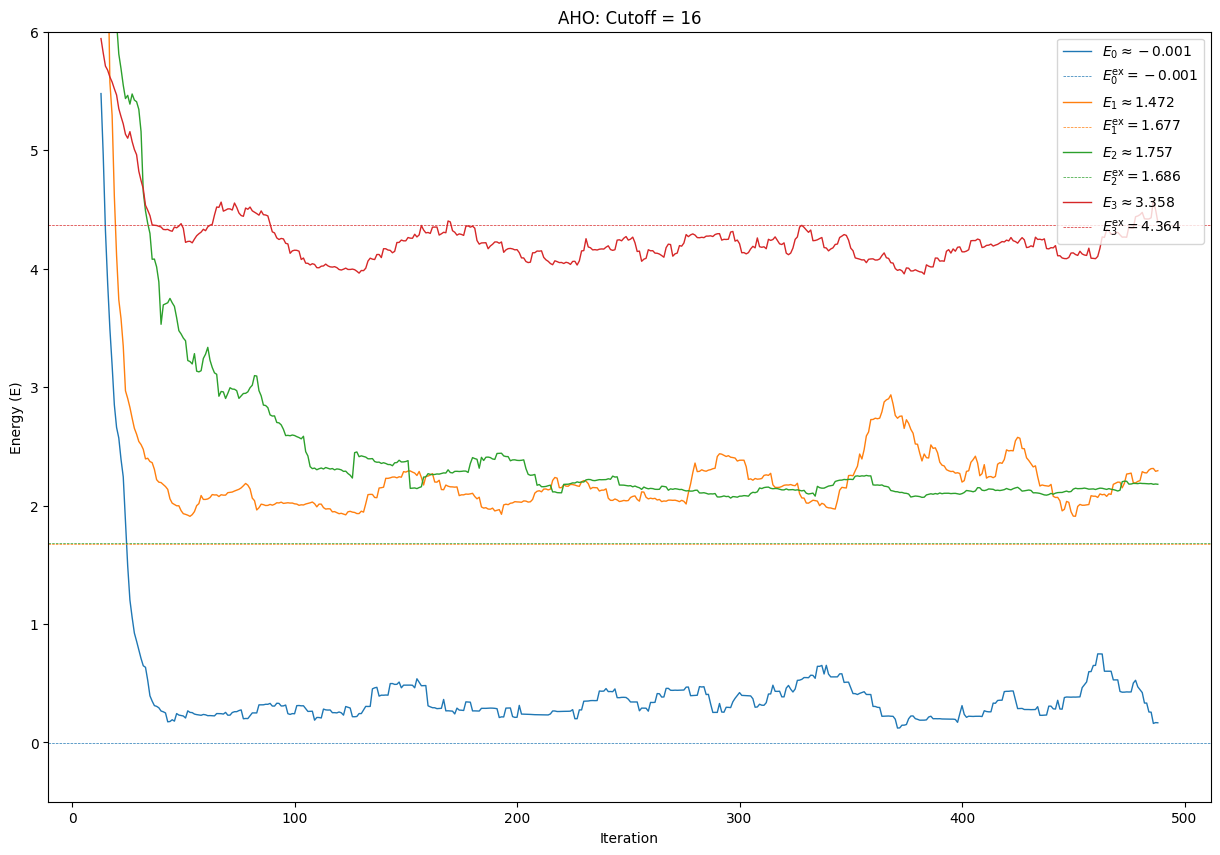

In [43]:
potential = 'AHO'
cut_off = 16
base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\SUSY\PennyLane\VQD\Differential Evolution\Shot Noise\AHO\2024-11-16_14-28-55\\"

# Plotting each line for different states
plt.figure(figsize=(15, 10))  # Set figure size similar to the uploaded image

for i in range(data['num_VQD']):
    smoothed_energies = savgol_filter(data['energies'][i], window_length=51, polyorder=2)
    smoothed_energies = pd.Series(data['energies'][i]).rolling(window=25, center=True).mean()
    #smoothed_energies = gaussian_filter(data['energies'][i], sigma=4)
    line, = plt.plot(data['num_iters'][i], smoothed_energies, linewidth=1.0, label=f"$E_{{{i}}} \\approx {data['converged_energies'][i]:.3f}$")
    plt.axhline(data['exact_eigenvalues'][i], color = line.get_color(), linestyle='--', linewidth=0.5, label=f"$E_{{{i}}}^{{\\text{{ex}}}} = {data['exact_eigenvalues'][i]:.3f}$")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("Energy (E)")
plt.title("Energy Convergence for Each Computed State")
plt.title(f"{potential}: Cutoff = {data['cutoff']}")

plt.ylim(-0.5, 6)

plt.legend(loc="upper right")

# Show plot
#plt.show()
plt.savefig(base_path + 'Smoothed-VQD-{}-{}.png'.format(potential,cut_off))
